## Decline Curve Analysis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df=pd.read_csv("norne_production_rate_sample.csv")

In [3]:
df.head()

,Date,Rate (SCF/d)
0,2004-04-01,2706039.0
1,2004-05-01,2492086.2
2,2004-06-02,1816846.1
3,2004-07-02,1920207.4
4,2004-07-04,1683521.4


In [4]:
df['Date']=pd.to_datetime(df['Date'],format='%Y-%m-%d')

In [5]:
df['Date']

0    2004-04-01
1    2004-05-01
2    2004-06-02
3    2004-07-02
4    2004-07-04
        ...    
59   2006-11-01
60   2006-11-09
61   2006-11-11
62   2006-11-17
63   2006-12-01
Name: Date, Length: 64, dtype: datetime64[ns]

In [6]:
t=df['Date']
q=df['Rate (SCF/d)']

###### Here, we need to take concern. In a production data (that will be ready for DCA analysis), the time axis should be displayed as days (from 0 to N days), not as dates. The following scripts do the conversion.

In [7]:
import datetime

In [8]:
## Subtract One datetime to another datetime
timedelta=[j-i for i, j in zip(t[:-1], t[1:])]
timedelta=np.array(timedelta)
timedelta = timedelta / datetime.timedelta(days=1)


In [9]:
timedelta

array([30.0, 32.0, 30.0, 2.0, 21.0, 7.0, 15.0, 1.0, 18.0, 16.0, 11.0,
       31.0, 33.0, 32.0, 10.0, 14.0, 4.0, 31.0, 19.0, 1.0, 9.0, 24.0, 6.0,
       30.0, 1.0, 24.0, 4.0, 10.0, 7.0, 12.0, 3.0, 2.0, 1.0, 28.0, 15.0,
       18.0, 35.0, 23.0, 1.0, 29.0, 2.0, 17.0, 15.0, 22.0, 6.0, 33.0,
       25.0, 7.0, 28.0, 27.0, 31.0, 14.0, 1.0, 15.0, 13.0, 17.0, 9.0, 5.0,
       17.0, 8.0, 2.0, 6.0, 14.0], dtype=object)

In [10]:
# take cumulative sum over timedeltas
t = np.cumsum(timedelta)
t = np.append(0, t)
t = t.astype(float)

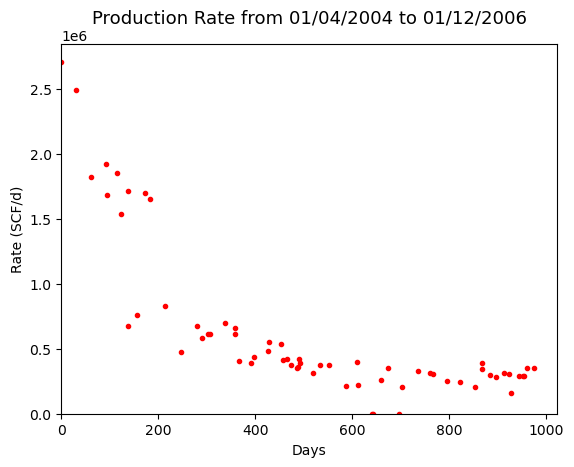

In [11]:
plt.plot(t, q, '.', color='red')
plt.title('Production Rate from 01/04/2004 to 01/12/2006', size=13, pad=15)
plt.xlabel('Days')
plt.ylabel('Rate (SCF/d)')
plt.xlim(xmin=0); plt.ylim(ymin=0)


plt.show()

##### On this data, we will now do a decline curve analysis using the non-linear regression (curve fitting) technique, that is available in the Scipy package. Before doing curve fitting, it's important to normalize our data, by dividing each time and rate values with their maximum values, so that values distribute from 0 to 1.

In [12]:
# normalize the time and rate data
t_normalized = t / max(t)
q_normalized = q / max(q)

#### Now, is our main part of the non-linear regression. We make the hyperbolic function, import the Scipy package, then we fit the function to the normalized data using the curve_fit method to produce the result of the three parameters: qi, di, and b.

In [13]:
## function for hyperbolic decline
def hyperbolic(t,qi,di,b):
    return qi / (np.abs((1 + b * di * t))**(1/b))

# fitting the data with the hyperbolic function
from scipy.optimize import curve_fit


popt, pcov = curve_fit(hyperbolic, t_normalized, q_normalized)
  


In [14]:
qi,di,b=popt

## #It takes less than a second. Now, we need to pay attention to. What we are going to do is to "de-normalize" our resulted parameters, since we do the regression on the normalized data. After a simple mathematical operation, the "de-normalized" version of the hyperbolic function looks like this.


## Hence, we need to multiply the resulted qi with the maximum value of q (or qmax), and to divide the resulted di with the maximum value of t (or tmax). After that, we print all the fitted parameters.

In [15]:
# de-normalize qi and di
qi = qi * max(q)
di = di / max(t)


print('Initial production rate:', np.round(qi, 3), 'MMSCF')
print('Initial decline rate:', np.round(di, 3), 'SCF/D')
print('Decline coefficient:', np.round(b, 3))

Initial production rate: 2866266.471 MMSCF
Initial decline rate: 0.007 SCF/D
Decline coefficient: 0.5


### We obtain the initial production rate equals 2.86 MMSCF per day, the initial decline rate equals 0.07 SCF per day, and most importantly the decline exponent equals 0.5. We are always interested to forecast how our production rate and cumulative production until 1,500 days will be. So next, this will be our task.
## The above equation is to calculate cumulative production (Qp). We create the function first.

In [16]:
# function for hyperbolic cumulative production
def cumpro(q_forecast, qi, di, b):
  return (((qi**b) / ((1 - b) * di)) * ((qi ** (1 - b)) - (q_forecast ** (1 - b))))  

## Then use the function to calculate the cumulative production with time extended to 1,500 days.

In [17]:
# forecast gas rate until 1,500 days
t_forecast = np.arange(1501)
q_forecast = hyperbolic(t_forecast, qi, di, b)


# forecast cumulative production until 1,500 days
Qp_forecast = cumpro(q_forecast, qi, di, b)

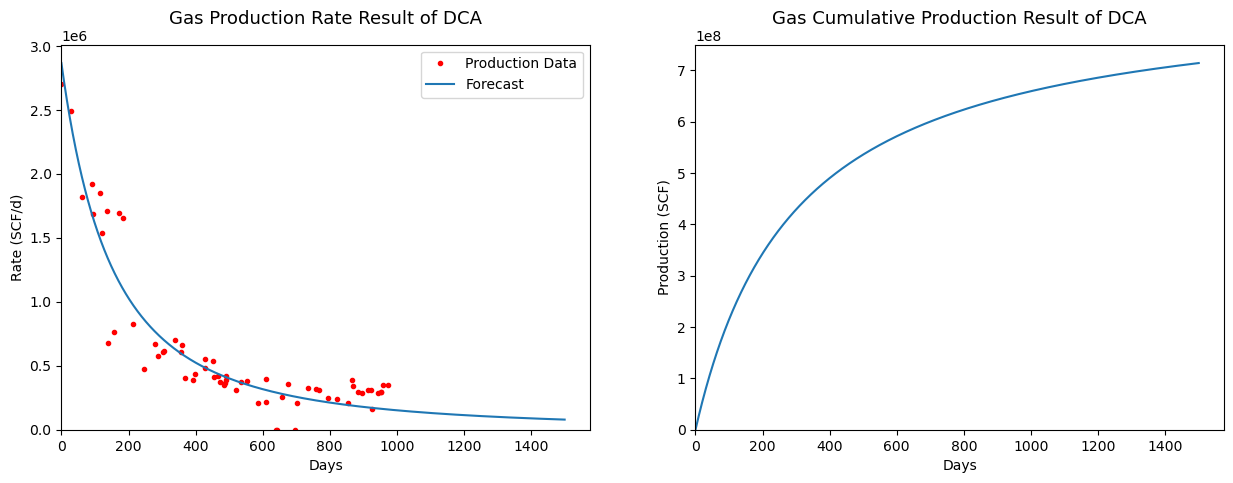

In [18]:
# plot the production data with the forecasts (rate and cum. production)
plt.figure(figsize=(15,5))


plt.subplot(1,2,1)
plt.plot(t, q, '.', color='red', label='Production Data')
plt.plot(t_forecast, q_forecast, label='Forecast')
plt.title('Gas Production Rate Result of DCA', size=13, pad=15)
plt.xlabel('Days')
plt.ylabel('Rate (SCF/d)')
plt.xlim(xmin=0); plt.ylim(ymin=0)
plt.legend()


plt.subplot(1,2,2)
plt.plot(t_forecast, Qp_forecast)
plt.title('Gas Cumulative Production Result of DCA', size=13, pad=15)
plt.xlabel('Days')
plt.ylabel('Production (SCF)')
plt.xlim(xmin=0); plt.ylim(ymin=0)


plt.show()

In [19]:
q_forecast

array([2866266.47117721, 2847185.38929013, 2828294.21605639, ...,
         79329.74548203,   79241.52826438,   79153.45811812])

In [20]:
Qp_forecast

array([0.00000000e+00, 2.85671000e+06, 5.69443408e+06, ...,
       7.14292894e+08, 7.14372180e+08, 7.14451378e+08])

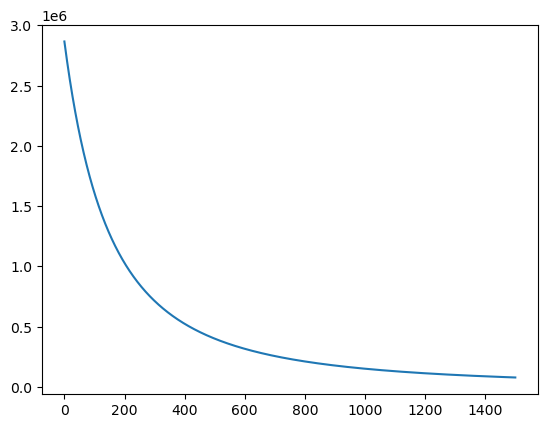

In [21]:
plt.plot(t_forecast, q_forecast, label='Forecast')